In [1]:
%load_ext autoreload
%autoreload 2

import autorootcwd # Do not delete - adds the root of the project to the path

### Data loading & processing

In [19]:
import torch

from ml.data import load_data

device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128

data, selected = load_data("data_processing/output")

print(data)

data_cut = data[selected]
data_rest = data[~selected]

print(data_cut)
print(data_rest)

# For reproducibility
torch.manual_seed(0)

trn_cut, val, tst, (i_trn_cut, i_val, i_tst) = data_cut.split(0.8, return_indices=True)
trn_uncut = trn_cut + data_rest

print(trn_cut)
print(trn_uncut)
print(val)

signal_idx = val.y_names.index("ttH")
print(f"{signal_idx=}")

Loading data:   0%|          | 0/12 [00:00<?, ?it/s]

Loading data: 100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


Data(n_samples=8874951, n_features=113, n_classes=17)
Data(n_samples=32768, n_features=113, n_classes=17)
Data(n_samples=8842183, n_features=113, n_classes=17)
Data(n_samples=26214, n_features=113, n_classes=17)
Data(n_samples=8868397, n_features=113, n_classes=17)
Data(n_samples=6554, n_features=113, n_classes=17)
signal_idx=0


### Training

##### Find the optimal LR for a given model

Searching for the optimal LR:   1%|          | 1/100 [01:17<2:08:13, 77.72s/it]


Interrupted
Found lr=0.00000 with min_loss=2.94731


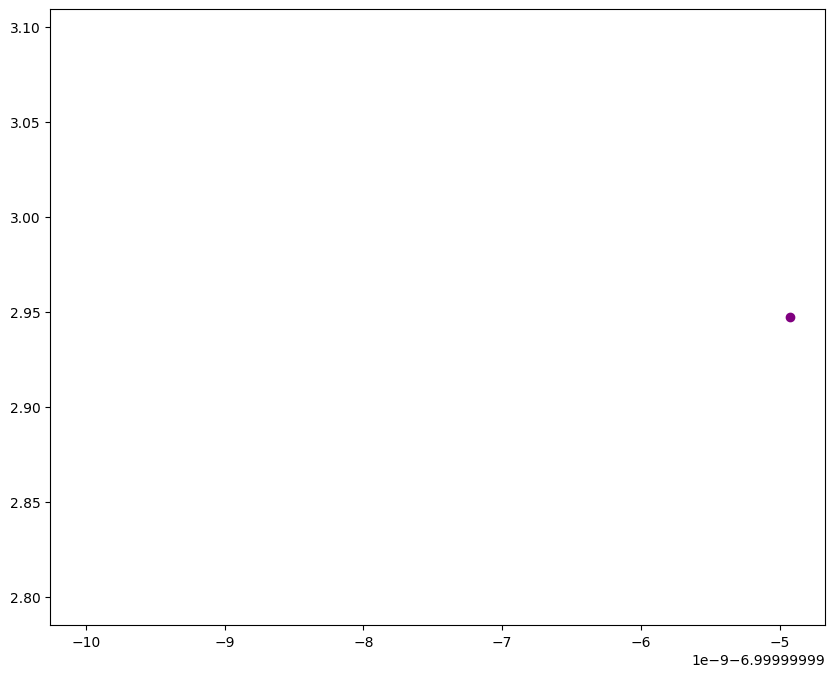

In [5]:
import torch
import matplotlib.pyplot as plt

from ml.nn import Transformer, ResNet
from ml.training import find_lr


def get_model():
    torch.manual_seed(0)  # For reproducibility

    # model = Transformer(
    #     trn_cut.n_features_continuous,
    #     trn_cut.categorical_sizes,
    #     trn_cut.n_classes,
    #     n_embed=32,
    #     n_blocks=2,
    #     n_heads=4,
    #     dropout=0,
    # )

    model = ResNet(
        trn_uncut.n_features_continuous,
        trn_uncut.categorical_sizes,
        trn_uncut.n_classes,
        n_embed=64,
        n_blocks=4,
        dropout=0.2,
        use_embedding=True,
    ).to(device)

    model = torch.compile(model)
    model = model.to(device)

    return model

model = get_model()

def Optim(params, lr):
    return torch.optim.Adam(params, lr=lr)


lr, min_loss = find_lr(model,
                       trn_cut,
                       Optim,
                       batch_size=batch_size,
                       lr_divisions=100,
                       ax=plt.subplots(figsize=(10, 8))[1],
                       device=device, 
                       half=None)
print(f"Found lr={lr:.5f} with min_loss={min_loss:.5f}")

##### Train the model

In [4]:
from ml.training import train
from ml.evaluation import evaluate

# Create the model, optimizer, and scheduler
model = get_model()
optim = Optim(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=500, factor=0.1, threshold=0.01, verbose=True, min_lr=1e-7)

# Train. Obtain the checkpoints of the best and the last models
model.train()

trn = trn_cut

# Get a single batch from trn
# batch_size = 128
# batch = next(iter(trn.batches(batch_size)))
# trn = batch

val = val

F = (trn.n_samples + val.n_samples) /  val.n_samples  # This is different - to have "same" normalization factor

half = torch.float16

checkpoint_best, checkpoint_last = train(
    model,
    optim,
    trn,
    evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half),
    epochs=500,
    validate_freq=1,
    restart=True,
    use_tqdm=False,
    device=device,
    batch_size=batch_size,
    scheduler=scheduler,
    half=half,
    # wandb_run="transformer-debugging",
    )

fig, ax1 = plt.subplots(figsize=(12, 8))
fig, ax2 = plt.subplots(figsize=(12, 8))

evaluate.plot(checkpoint_last.stats, ax1, ax2)

# Load the best checkpoint
# load_checkpoint(model, kind="best")

# print(checkpoint_best.stats[-1])

Initial evaluation:
Epoch 0: val/loss=2.9610, trn/loss=2.9589, val/acc=2.40%, val/acc/bin=63.76%, val/f1=0.00%, AUC (mean)=0.543, AUC (ttH)=0.487, AUC (ttH) [RAW]=0.472, significance=2.08 (60.20% of max possible (3.46)) @ threshold=0.04

+    4s: Epoch 1: val/loss=1.3972, trn/loss=1.3945, val/acc=36.26%, val/acc/bin=38.50%, val/f1=53.80%, AUC (mean)=0.635, AUC (ttH)=0.650, AUC (ttH) [RAW]=0.598, significance=2.10 (60.70% of max possible (3.46)) @ threshold=0.29
+    4s: Epoch 2: val/loss=1.3604, trn/loss=1.3628, val/acc=38.64%, val/acc/bin=39.37%, val/f1=54.20%, AUC (mean)=0.690, AUC (ttH)=0.638, AUC (ttH) [RAW]=0.608, significance=2.10 (60.76% of max possible (3.46)) @ threshold=0.34
+    4s: Epoch 3: val/loss=1.3423, trn/loss=1.3402, val/acc=36.92%, val/acc/bin=46.32%, val/f1=51.37%, AUC (mean)=0.709, AUC (ttH)=0.634, AUC (ttH) [RAW]=0.619, significance=2.10 (60.76% of max possible (3.46)) @ threshold=0.27
+    4s: Epoch 4: val/loss=1.3245, trn/loss=1.3157, val/acc=39.24%, val/acc/bi

ValueError: too many values to unpack (expected 2)

# Loading the trained model

In [15]:
# Load the model
import os
from yaml import safe_load

from src.nn import Transformer, TransformerNN
from src.evaluation import evaluate

checkpoint = "checkpoints/transformer-best"

with open(os.path.join(checkpoint, "config.yaml")) as f:
    config = safe_load(f)

model = Transformer(
            config["n_features_continuous"],
            config["categorical_sizes"],
            config["n_classes"],
            n_embed=config["n_embed"],
            n_blocks=config["n_blocks"],
            n_heads=config["n_heads"],
            dropout=config["dropout"],
        )

# print(model.nn.embed.b_categorical)

model_opt = torch.compile(model)
model_opt.load_state_dict(torch.load(os.path.join(checkpoint, "model.pt")))

model.to(device);

In [23]:
# Loading the model from wandb
from ml.download_model import download_model
from ml.nn import Transformer

model_name = "transformers/transformer-2-10-data"

path = download_model(model_name)

model = Transformer.from_saved(path)

# Evaluate the model
model.eval()

print(model.hyperparameters)
print(val.n_features_continuous)


------------------------------------ Config ------------------------------------

seed: 0
use_wandb: True
project_name: mtcp
data_path: data_processing/output
use_binary: False
use_weights: False
use_embedding: False
use_nan_w: False
dropout: 0.0
n_embed_categorical: 8
cuts: discard
trn_split: 0.8
fraction: 0.1
compile: False
use_half: True
repeat: 1
batch_size: 1024
epochs: 200
tags: []
model: transformer
n_blocks: 2
n_embed: 256
n_heads: 4
run_name: transformer-2-10-data
device: cuda
cuda_device: 0
dtype: torch.float16
checkpoints_dir: ml/checkpoints

--------------------------------------------------------------------------------

{'n_embed': 256, 'n_inner': 1024, 'n_blocks': 2, 'n_heads': 4, 'n_classes': 17, 'n_parameters': 1657984, 'dropout': 0.0}
98


# Evaluations

### ROC curves

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

# Get probs on the validation set
with torch.no_grad():
    probs = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1).cpu()

for i in range(val.n_classes):
    fpr, tpr, _ = roc_curve(val.y, probs[:, i], pos_label=i)
    auc = np.trapz(tpr, fpr)

    fprw, tprw, _ = roc_curve(val.y, probs[:, i], pos_label=i, sample_weight=val.w.cpu())
    aucw = np.trapz(tprw, fprw)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(fpr, tpr, label=f"{val.y_names[i]} {auc:.4f}")
    ax.plot(fprw, tprw, label=f"{val.y_names[i]} (weighted) {aucw:.4f}")
    ax.plot([0, 1], [0, 1], linestyle="--", c="k", label="Chance")
    ax.set_ylabel("True positive rate")
    ax.set_xlabel("False positive rate")
    ax.set_title(f"ROC curve ({val.y_names[i]})")
    ax.legend()

    # print(f"{auc_custom=:.4f} {auc_sklearn=:.4f} n_points={len(fpr)}")

    # Now trully custom auc - calculate fpr tpr yourself
    # signal_probs = probs[:, 0]
    # print(len(np.unique(signal_probs)))

RuntimeError: The size of tensor a (98) must match the size of tensor b (111) at non-singleton dimension 1

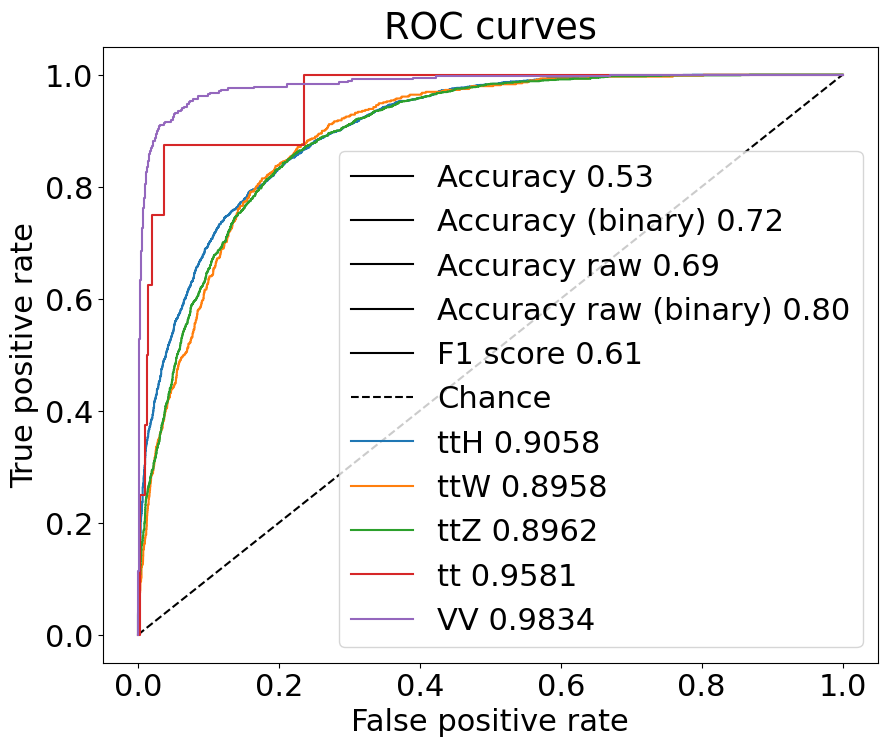

In [74]:
from src.evaluation import evaluate

# Get probs on the validation set
with torch.no_grad():
    probs = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1).cpu()

fig, ax = plt.subplots(figsize=(10, 8))

# Dummy plot to include accuracy in the legend
ax.plot([], [], label=f"Accuracy {evaluation.metrics['val/acc/multi']:.2f}", c="k")
ax.plot([], [], label=f"Accuracy (binary) {evaluation.metrics['val/acc/bin']:.2f}", c="k")

ax.plot([], [], label=f"Accuracy raw {evaluation.metrics['val/acc/multi_raw']:.2f}", c="k")
ax.plot([], [], label=f"Accuracy raw (binary) {evaluation.metrics['val/acc/bin_raw']:.2f}", c="k")

# Dummy plot for the f1 score
ax.plot([], [], label=f"F1 score {evaluation.metrics['val/f1']:.2f}", c="k")

ax.plot([0, 1], [0, 1], linestyle="--", c="k", label="Chance")

classes = ["ttH", "ttW", "ttZ", "tt", "VV"]
for c in classes:
    i = val.y_names.index(c)
    fpr, tpr, _ = roc_curve(val.y, probs[:, i], pos_label=i)
    auc = np.trapz(tpr, fpr)

    ax.plot(fpr, tpr, label=f"{val.y_names[i]} {auc:.4f}")

ax.set_ylabel("True positive rate")
ax.set_xlabel("False positive rate")
ax.set_title(f"ROC curves")
ax.legend()

    # print(f"{auc_custom=:.4f} {auc_sklearn=:.4f} n_points={len(fpr)}")

    # Now trully custom auc - calculate fpr tpr yourself
    # signal_probs = probs[:, 0]
    # print(len(np.unique(signal_probs)))

In [5]:
from src.training import evaluate

trn = trn_cut
F = 5
half = torch.float16
print(evaluate.using(model, trn, val, "ttH", device=device, use_tqdm=False, F=F, batch_size=batch_size, half=half)(123))

Epoch 123: val/loss=0.9249, trn/loss=0.7544, val/acc=52.92%, val/acc_bin=72.32%, val/f1=60.07%, AUC (mean)=0.903, AUC (ttH)=0.892, significance=2.28 (64.43% of max possible (3.54)) @ threshold=0.45


### AUROC

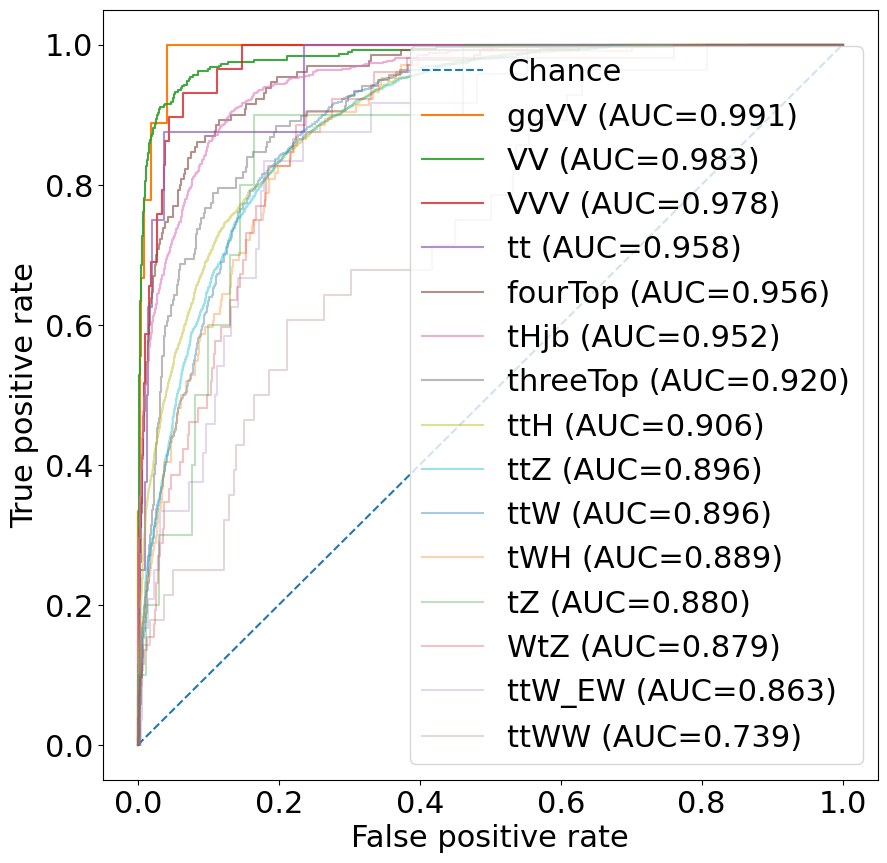

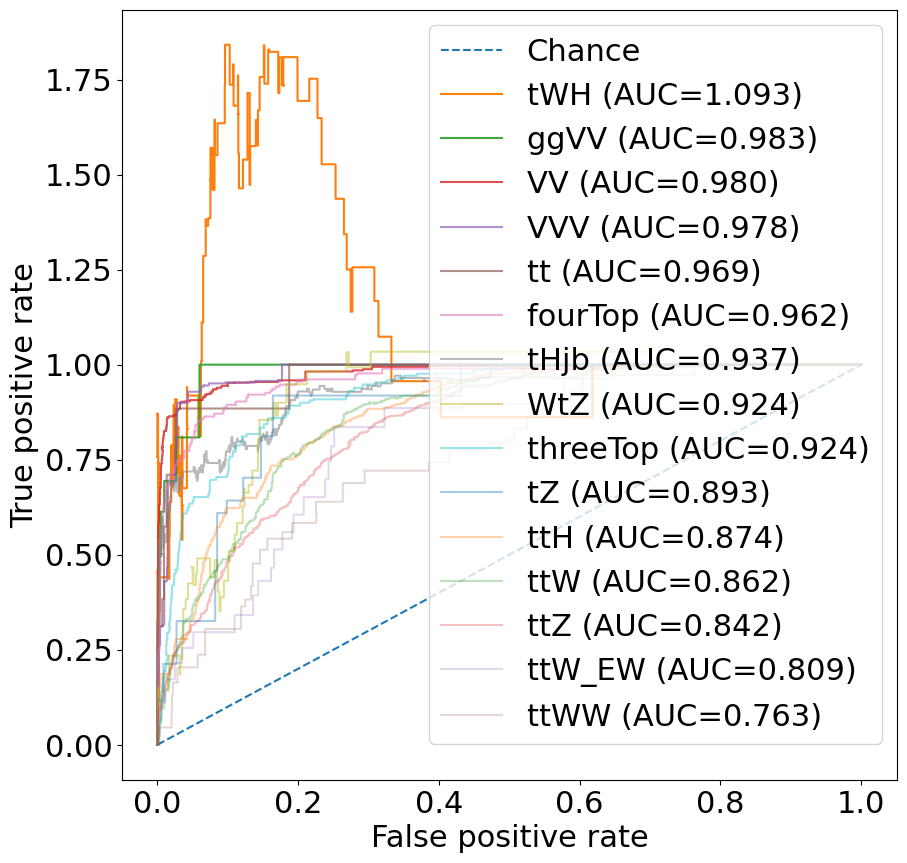

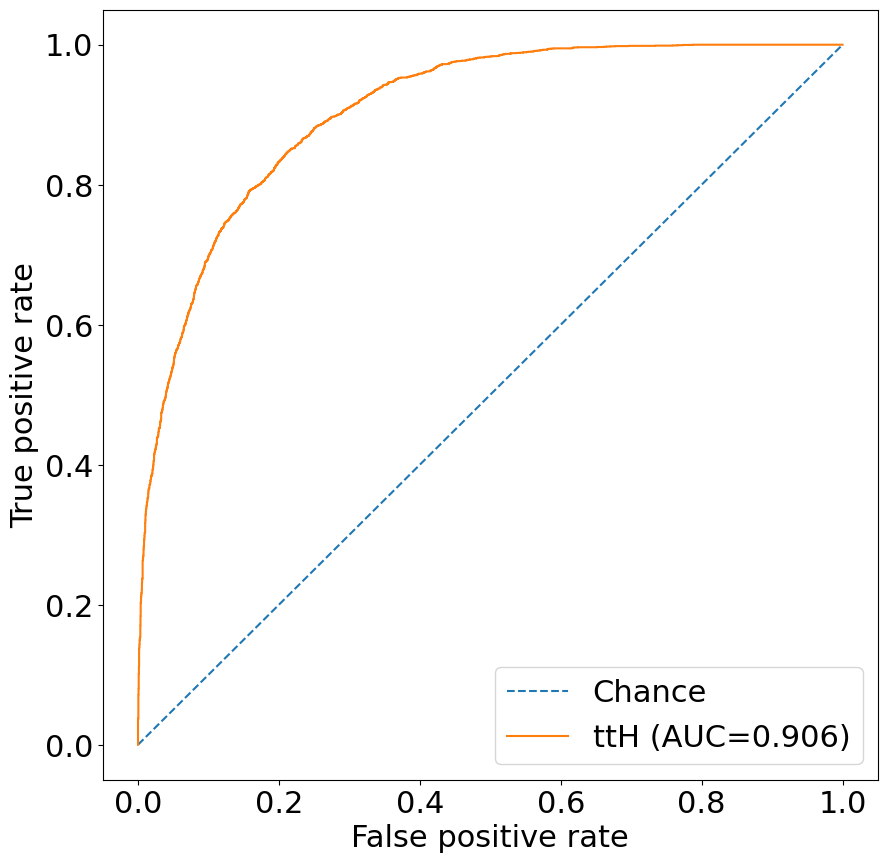

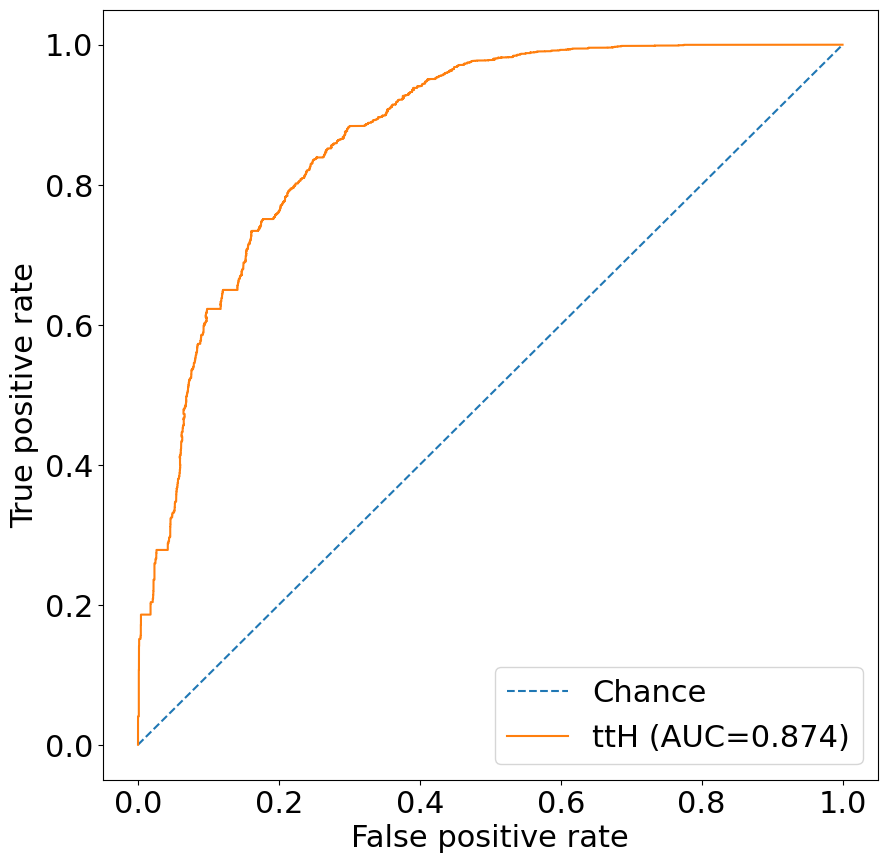

In [52]:
from src.evaluation import plot_roc

plot_roc(model, val, device=device, batch_size=batch_size)
plot_roc(model, val, device=device, batch_size=batch_size, use_weights=True)
plot_roc(model, val, class_idx=val.y_names.index("ttH"), device=device)
plot_roc(model, val, class_idx=val.y_names.index("ttH"), device=device, use_weights=True)

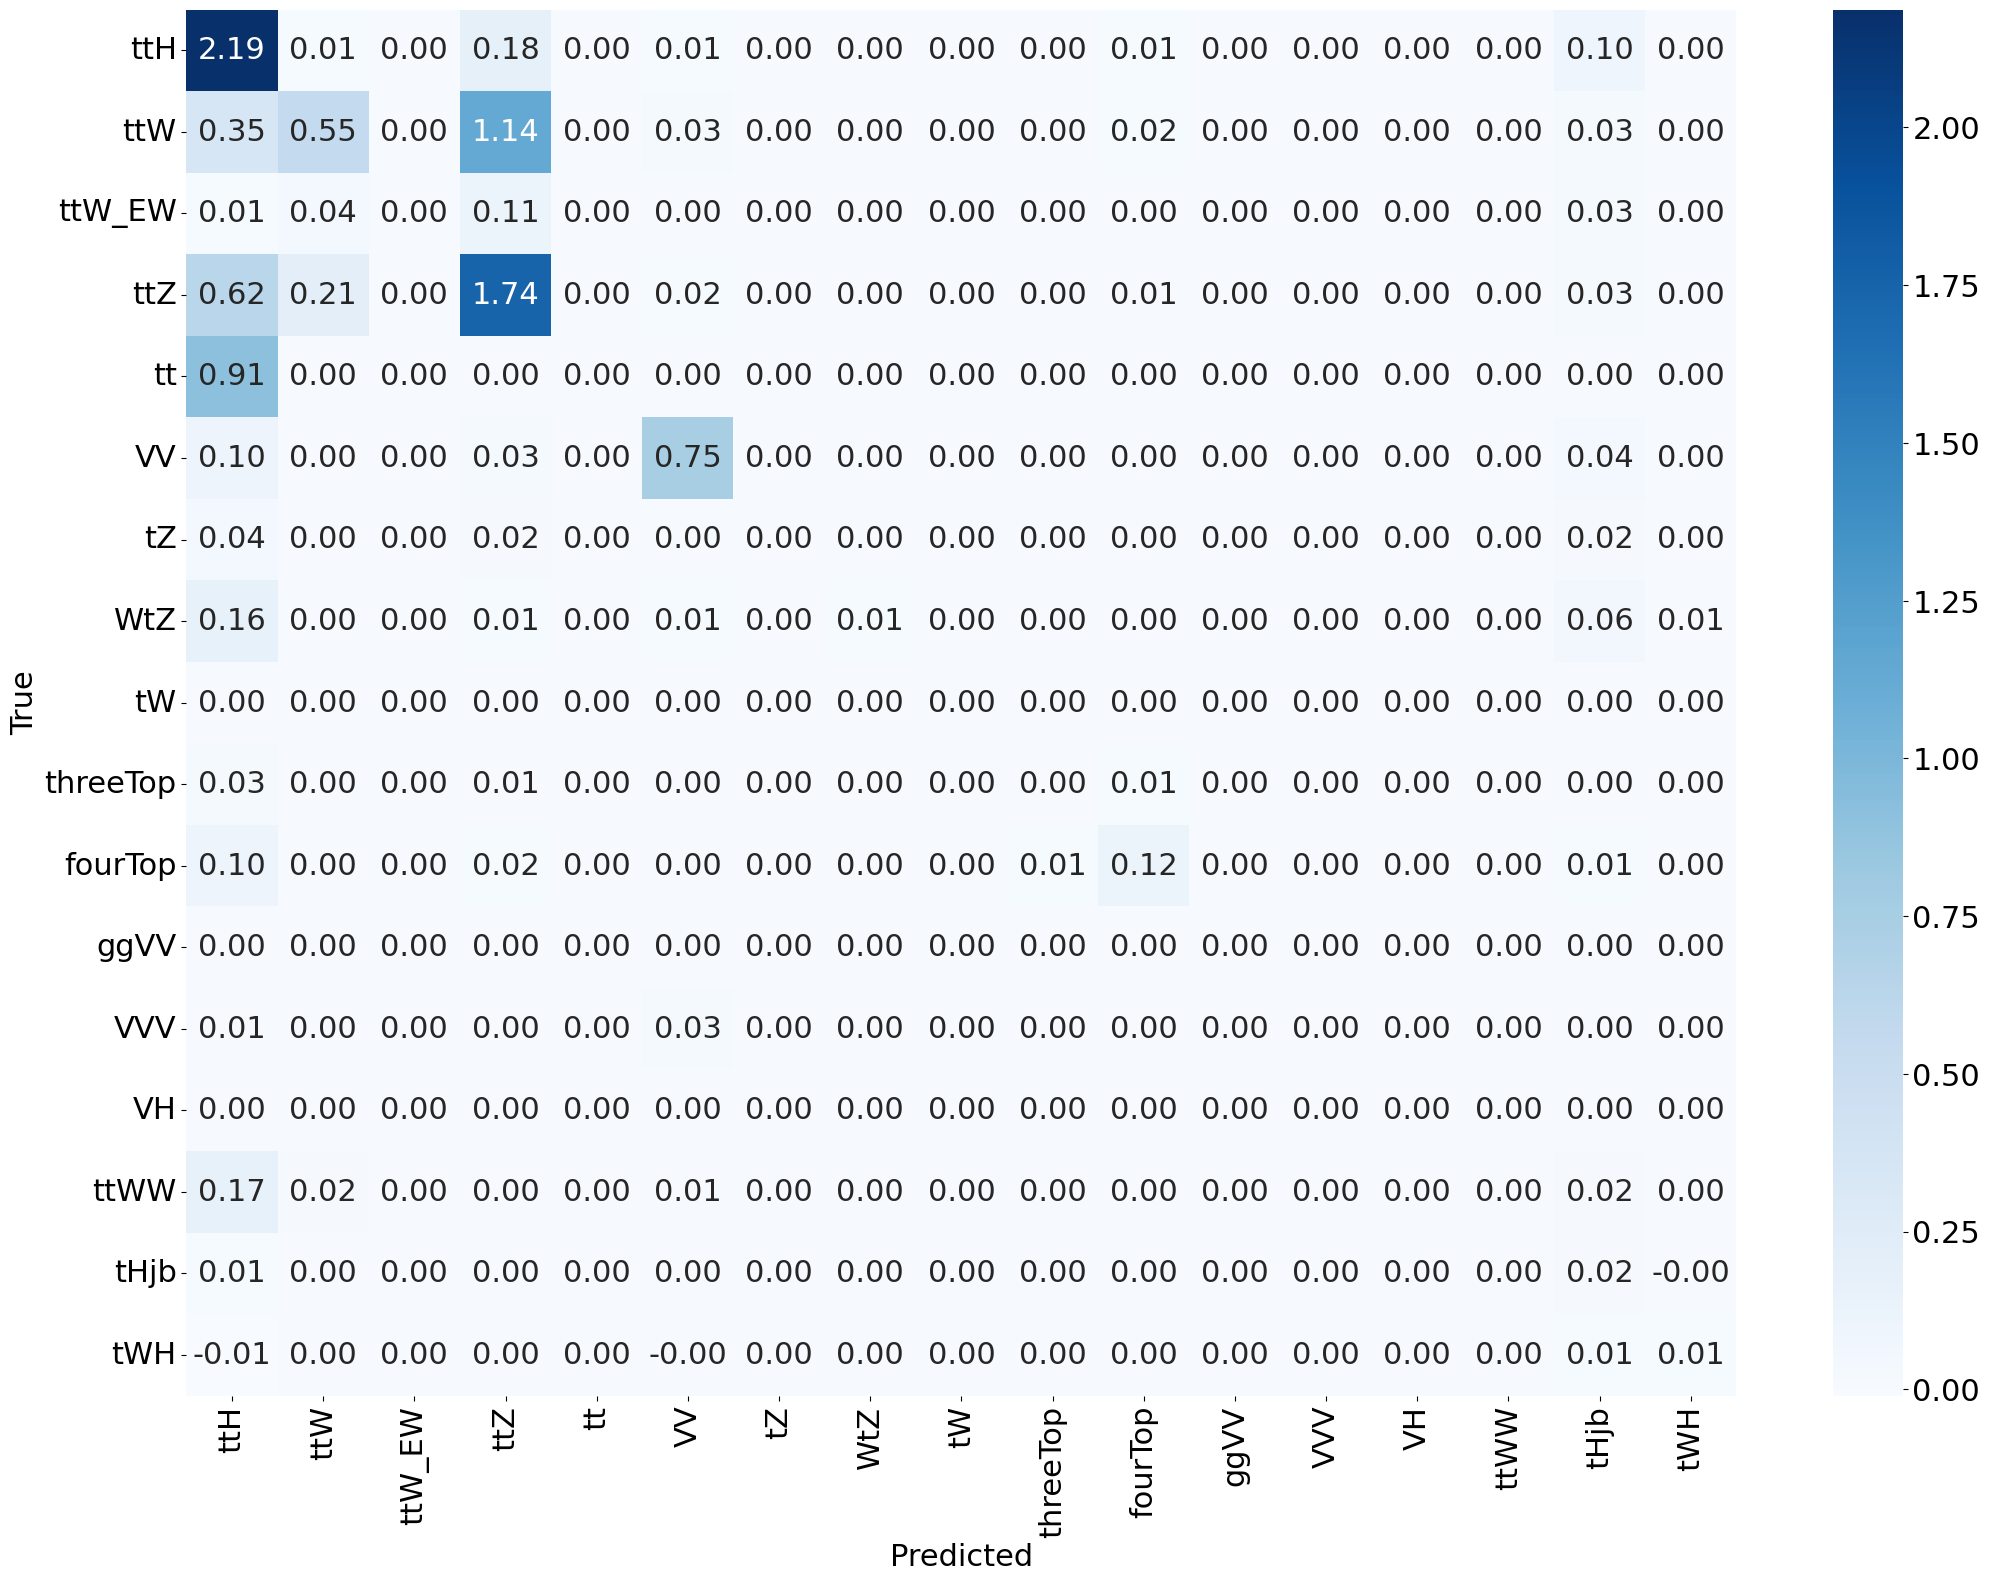

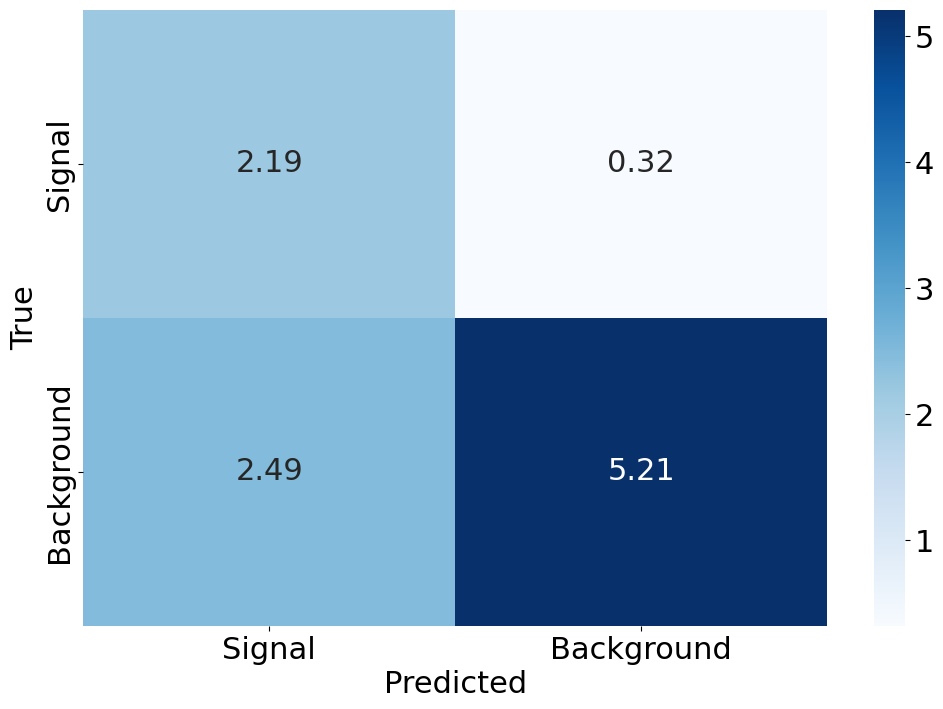

In [33]:
from src.evaluation import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = torch.cat([model.predict(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(25, 18))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

### Significance


How it's calculated:

- We get class probabilities from our model.

- We then take a look at the probability for our signal event (ttH).
  - **If the probability is greater than the threshold, we simply classify the event as signal.**
  - **Otherwise we pick the highest probability among all the other classes** (but this just means it's classified as background).

- Then we create a weighted confusion matrix.

- We calculate the scaling/nomralization factor $F = \frac{|\mathcal{T}_{trn}|}{|\mathcal{T}_{val}|}$.

- We calculate signal $s$ as the TPR, and background $b$ as the FPR.

- We calculate the significance as $S = \frac{s}{\sqrt{s+b}}\sqrt{F}$.

Maximum significance: 2.344034194946289 at threshold 0.630630612373352


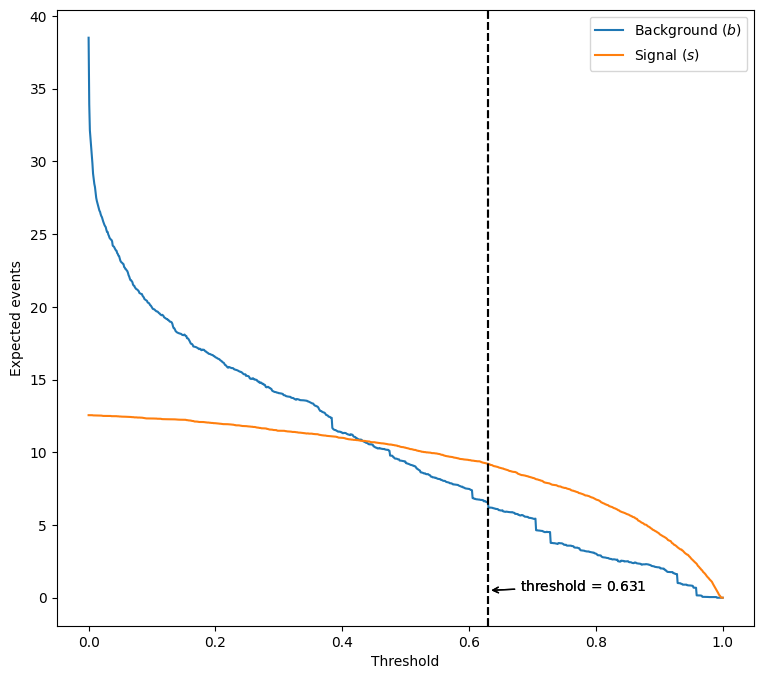

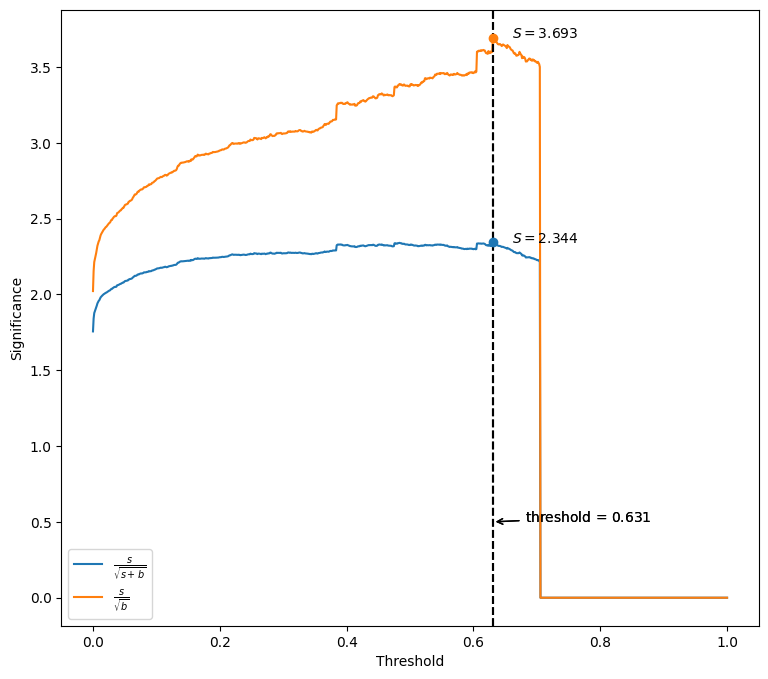

In [4]:
import matplotlib.pyplot as plt
from src.evaluation import find_significance_threshold


torch.set_printoptions(precision=3, sci_mode=False)

with torch.no_grad():
    logits = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).cpu()

# Probabilities
probs = torch.softmax(logits, dim=1)

# Now let's check all the thresholds where the significance is the highest
F = (trn_cut.n_samples + val.n_samples) / val.n_samples
threshold, significance, stats = find_significance_threshold(
    probs,
    val.y,
    val.w,
    val.y_names.index("ttH"),
    F,
    n_significance_thresholds=1000,
    return_stats=True,
    min_background=1,
)

threshold_simple, significance_simple, stats_simple = find_significance_threshold(
    probs,
    val.y,
    val.w,
    val.y_names.index("ttH"),
    F,
    n_significance_thresholds=1000,
    return_stats=True,
    include_signal=False,
    min_background=1,
)

print(f"Maximum significance: {significance} at threshold {threshold}")

# Let's also calculate the best possible significance we can get on the validation set. This happens if we classify all events correctly
# S_max = trn.max_significance()

# Plot two figures one below another
# First sub-figure:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))

# Plot the (expected) number of signal and background events
thresholds, significances, signals, backgrounds = zip(*[[si.cpu() for si in s] for s in stats])
thresholds_simple, significances_simple, *_ = zip(*[[si.cpu() for si in s] for s in stats_simple])

ax1.plot(thresholds, backgrounds, label=f"Background ($b$)")
ax1.plot(thresholds, signals, label=f"Signal ($s$)")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Expected events")

threshold = threshold.cpu()
significance = significance.cpu()
threshold_simple = threshold_simple.cpu()
significance_simple = significance_simple.cpu()

# Plot the dashed vertical line at the best threshold and annotate it
ax1.axvline(threshold, linestyle="--", color="black")
ax1.annotate(f"threshold = ${threshold:.3f}$", (threshold, 0.5), (threshold + 0.05, 0.5), arrowprops=dict(arrowstyle="->"))

ax1.axvline(threshold_simple, linestyle="--", color="black")
ax1.annotate(f"threshold = ${threshold_simple:.3f}$", (threshold_simple, 0.5), (threshold_simple + 0.05, 0.5), arrowprops=dict(arrowstyle="->"))

# Plot points at the number of signal and background events at the best threshold and annotate them
# i = thresholds.index(threshold)
# ax1.scatter(threshold, signals[i], color="C0", zorder=10)
# ax1.annotate(f"$s={signals[threshold]:.3f}$", (thresholds[threshold], signals[threshold]), (thresholds[threshold] + 0.02, signals[threshold] + 0.5))
# ax1.scatter(thresholds[threshold], backgrounds[threshold], color="C1", zorder=10)
# ax1.annotate(f"$b={backgrounds[threshold]:.3f}$", (thresholds[threshold], backgrounds[threshold]), (thresholds[threshold] - 0.2, backgrounds[threshold] - 0))
ax1.legend()

# Second subfigure
fig, ax2 = plt.subplots(1, 1, figsize=(9, 8))

# Plot the significance
ax2.plot(thresholds, significances, label=r"$\frac{s}{\sqrt{s+b}}$")
ax2.plot(thresholds_simple, significances_simple, label=r"$\frac{s}{\sqrt{b}}$")

# Plot the dashed vertical line at the best threshold and annotate it
ax2.axvline(threshold, linestyle="--", color="black")
ax2.annotate(f"threshold = ${threshold:.3f}$", (threshold, 0.5), (threshold + 0.05, 0.5), arrowprops=dict(arrowstyle="->"))

ax2.axvline(threshold_simple, linestyle="--", color="black")
ax2.annotate(f"threshold = ${threshold_simple:.3f}$", (threshold_simple, 0.5), (threshold_simple + 0.05, 0.5), arrowprops=dict(arrowstyle="->"))

# Plot points at the significance at the best threshold and annotate it
ax2.scatter(threshold, significance, color="C0", zorder=10)
ax2.annotate(f"$S={significance:.3f}$", (threshold, significance), (threshold + 0.03, significance - 0.0))

ax2.scatter(threshold_simple, significance_simple, color="C1", zorder=10)
ax2.annotate(f"$S={significance_simple:.3f}$", (threshold_simple, significance_simple), (threshold_simple + 0.03, significance_simple - 0.0))

ax2.legend(loc="lower left")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Significance");

### Confusion matrix

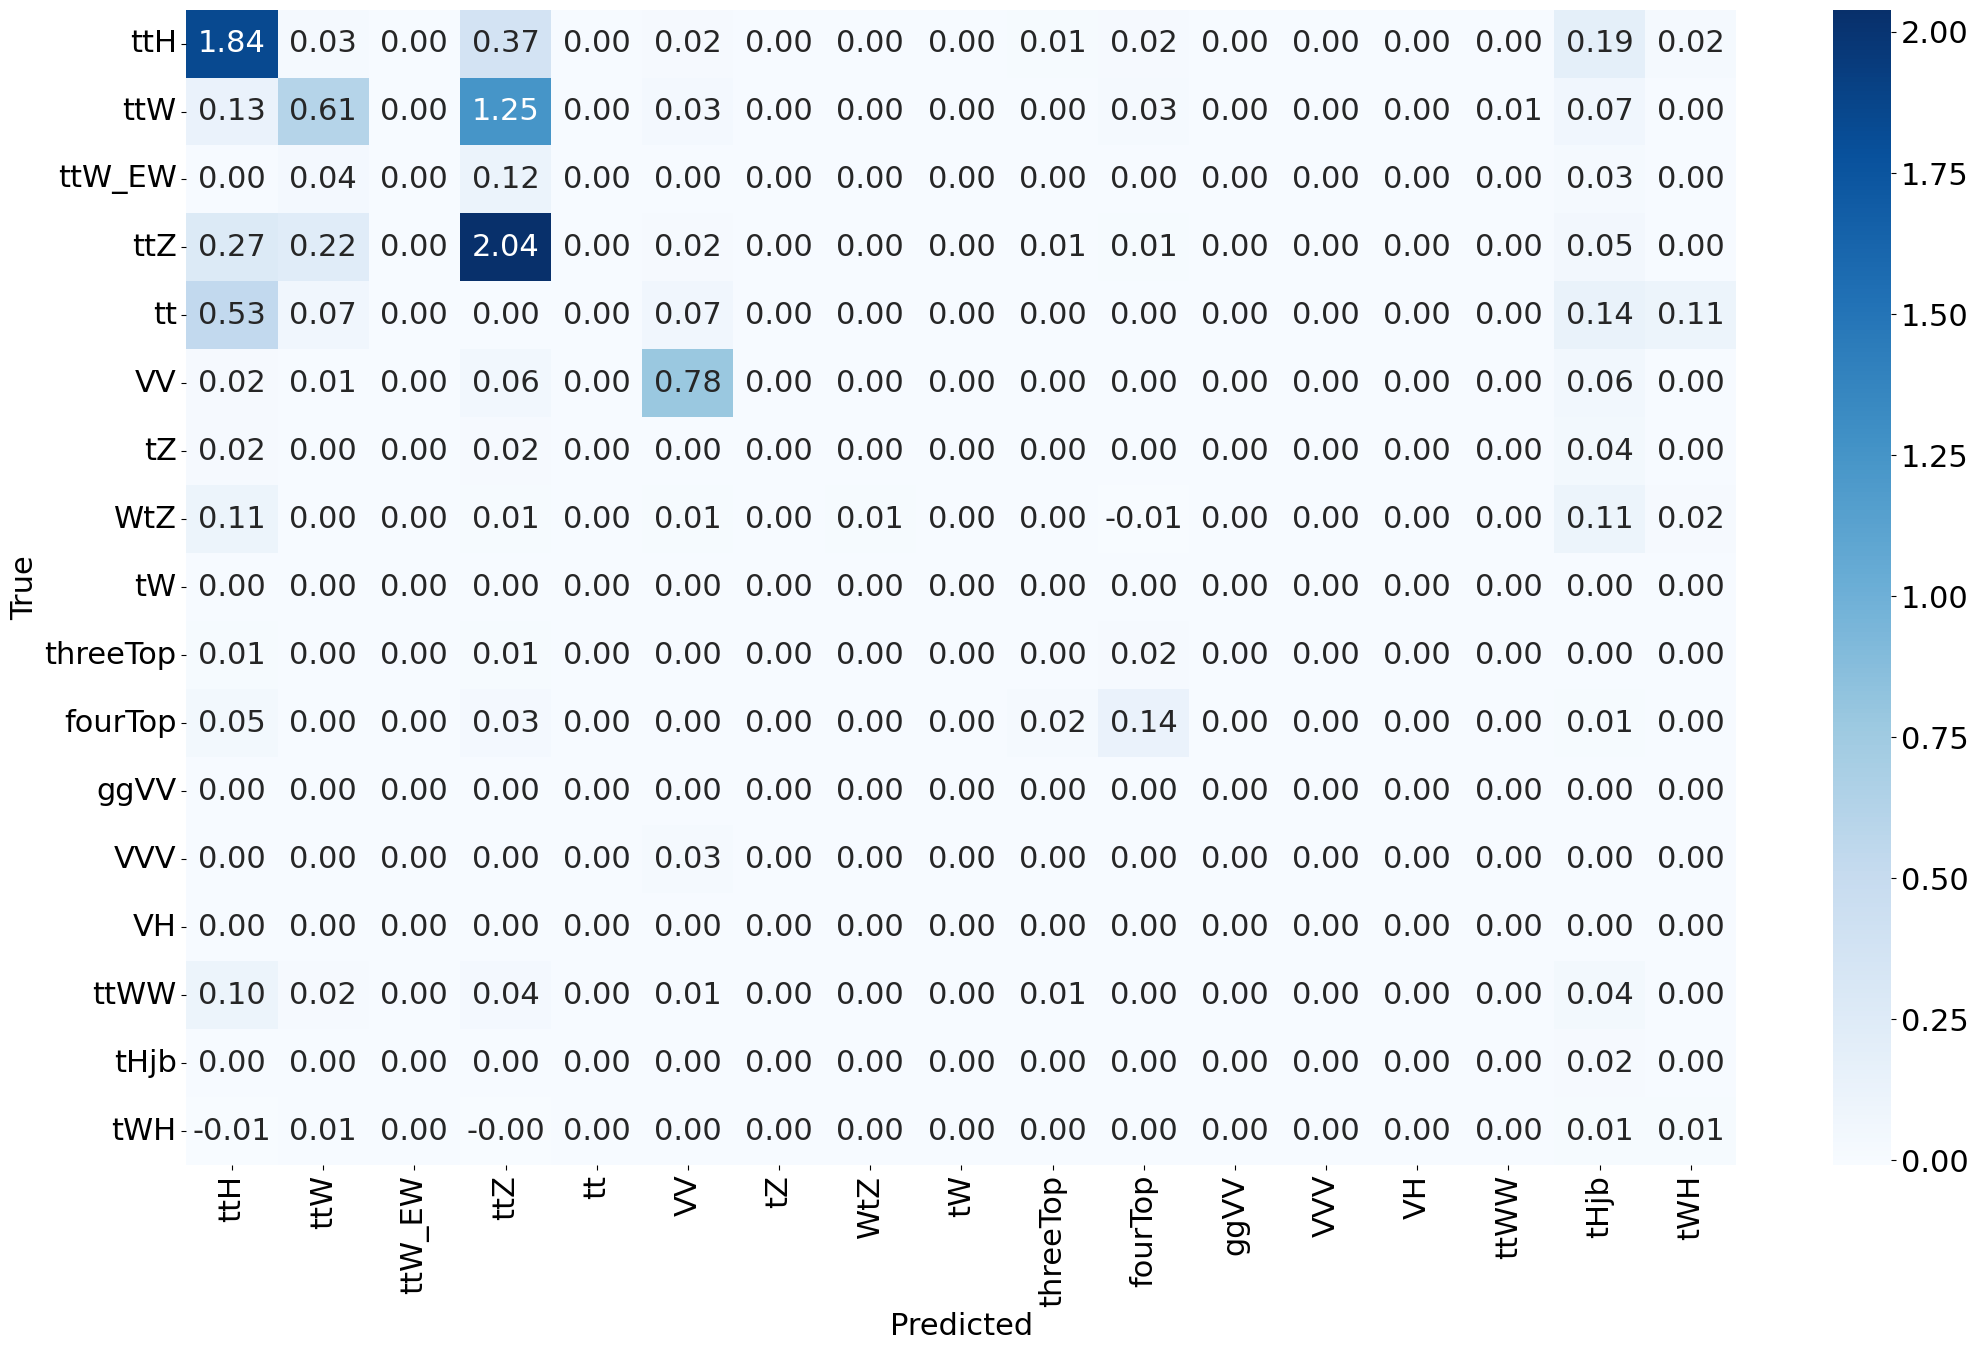

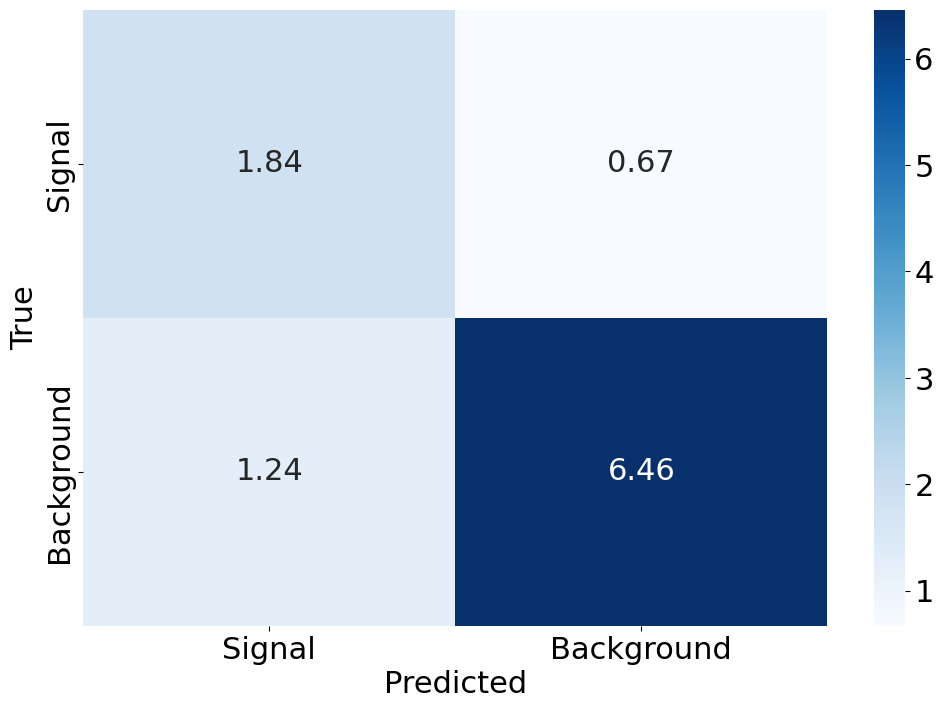

In [34]:
from src.evaluation import confusion_matrix
import seaborn as sns


signal_idx = val.y_names.index("ttH")
y_pred = torch.cat([
    model.predict(batch.to(device), threshold=threshold, signal_idx=signal_idx) 
    for batch in val.batches(batch_size=batch_size, shuffle=False)
]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(25, 15))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

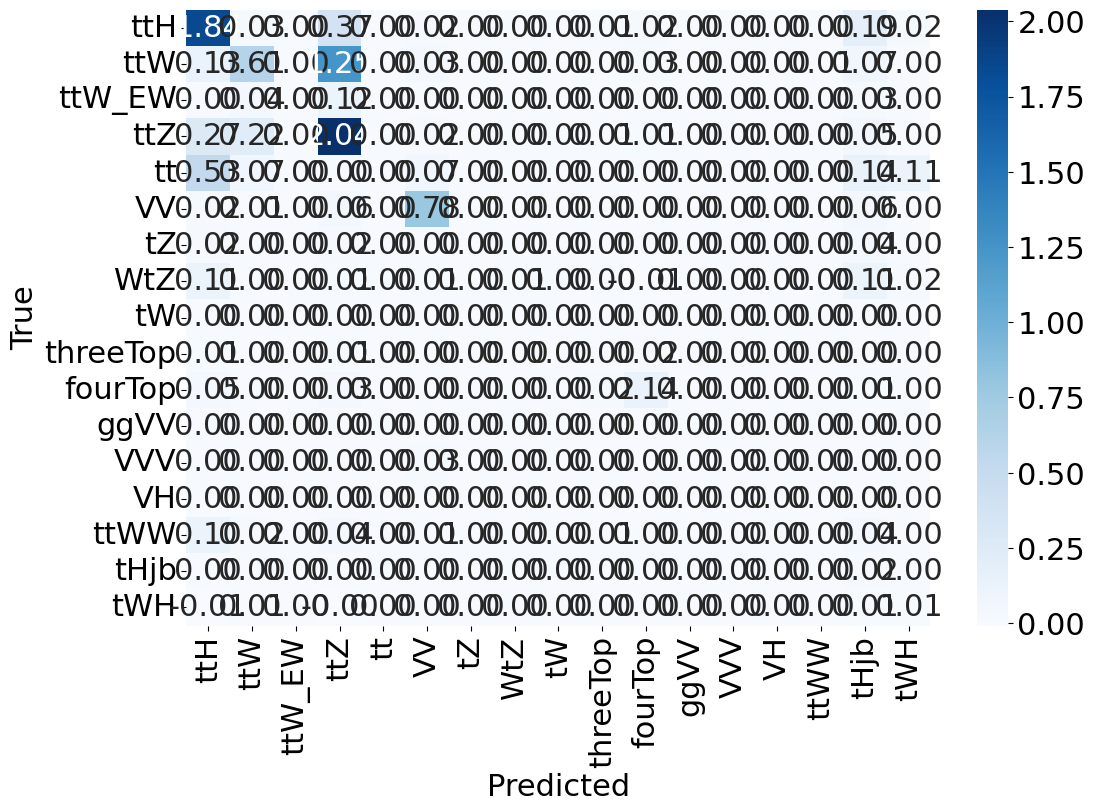

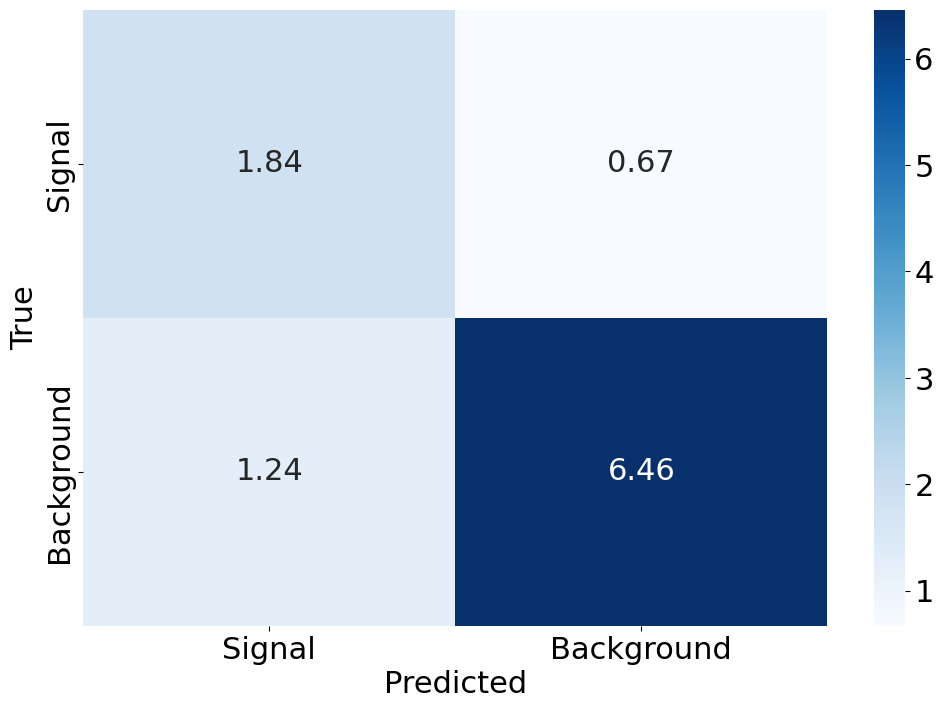

In [35]:
from src.evaluation import confusion_matrix
import seaborn as sns


signal_idx = val.y_names.index("ttH")
y_pred = torch.cat([
    model.predict(batch.to(device), threshold=threshold_simple, signal_idx=signal_idx) 
    for batch in val.batches(batch_size=batch_size, shuffle=False)
]).cpu()

# Plot CM for all the classes
cm = confusion_matrix(y_pred, val.y, val.w, n_classes=val.n_classes)

_, ax1 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax1, xticklabels=val.y_names, yticklabels=val.y_names, fmt=".2f")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")

# Now plot CM for just the signal class
cm = confusion_matrix(y_pred, val.y, val.w, signal=val.y_names.index("ttH"))

_, ax2 = plt.subplots(figsize=(12, 8))
sns.heatmap(cm.cpu(), annot=True, cmap="Blues", cbar=True,  ax=ax2, xticklabels=["Signal", "Background"], yticklabels=["Signal", "Background"], fmt=".2f")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("True");

### Feature importance

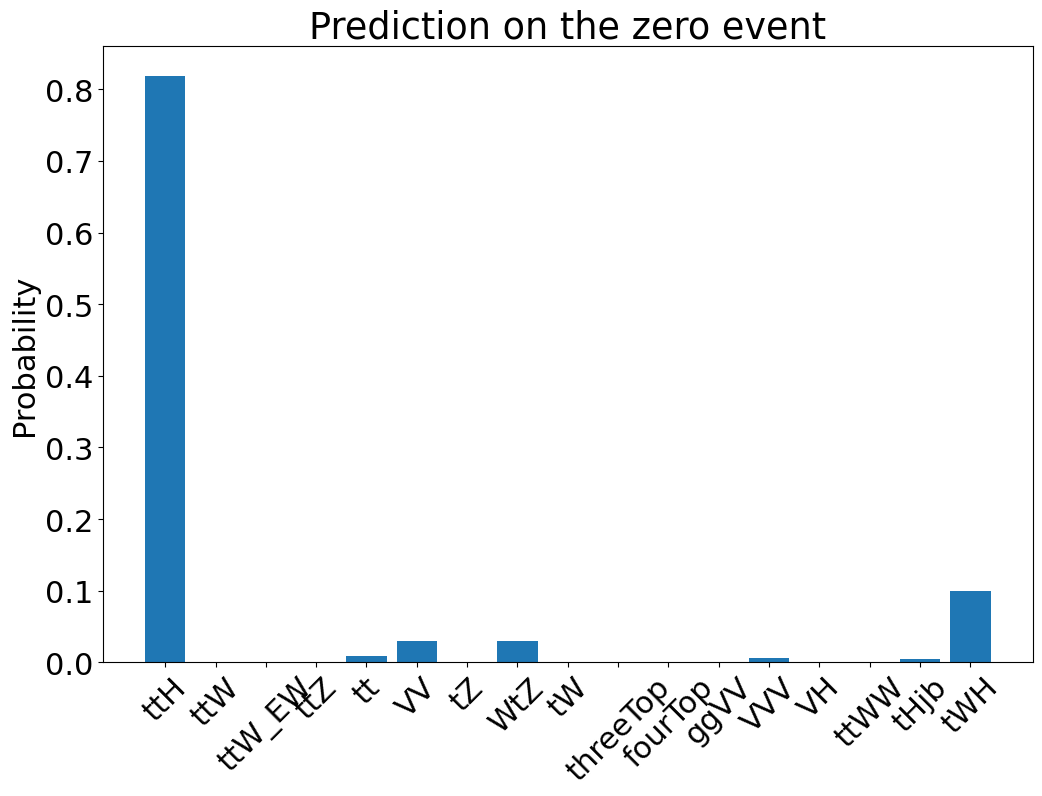

In [41]:
from src.data import Data

# First, let's see what is the prediciton on the empty event
# There is a problem that a zero tensor is not actually an empty event, but let's ignore that for now
# (by the way, Severin also uses just zero tensors for the empty event)
sample = val[[0]]
baseline = Data.zeros(val.n_features_continuous, val.categorical_sizes, **val.metadata)

model.eval()
with torch.no_grad():
    probs = model(baseline.to(device)).softmax(dim=1).view(-1) # Get the probabilities

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(torch.arange(val.n_classes), probs.cpu())
ax.set_xticks(torch.arange(val.n_classes), val.y_names, rotation=45)
ax.set_ylabel("Probability")
ax.set_title("Prediction on the zero event");

In [2]:
import wandb

run = wandb.init(project="ttH", name="test-test")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: elumixor. Use `wandb login --relogin` to force relogin


In [7]:
run

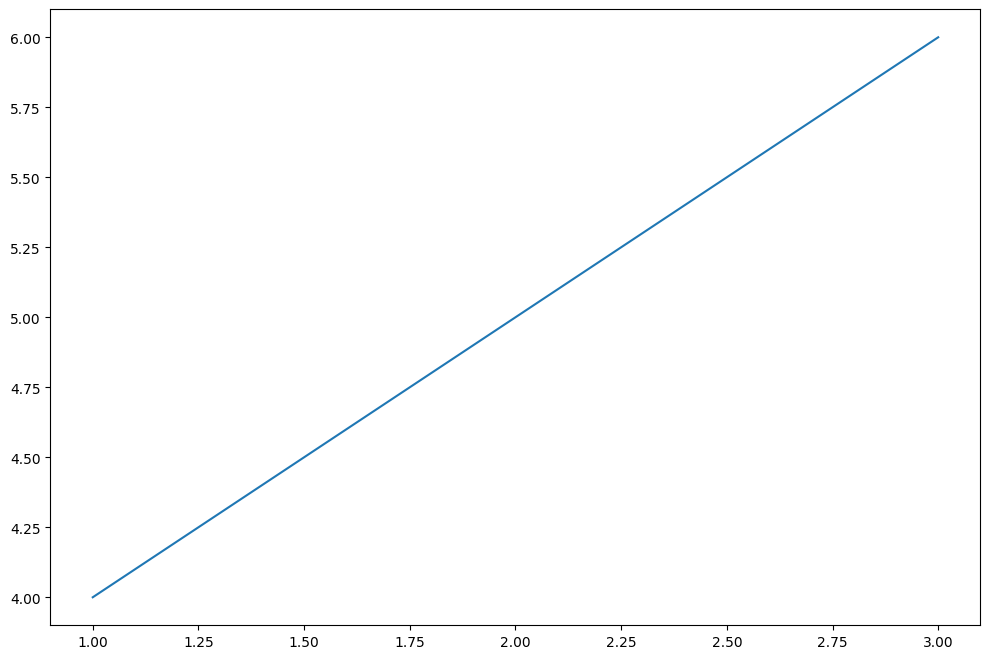

In [9]:
# Plut a dummy plot to see if it works
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([1, 2, 3], [4, 5, 6])

run.log({"test": wandb.Image(fig)})

100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


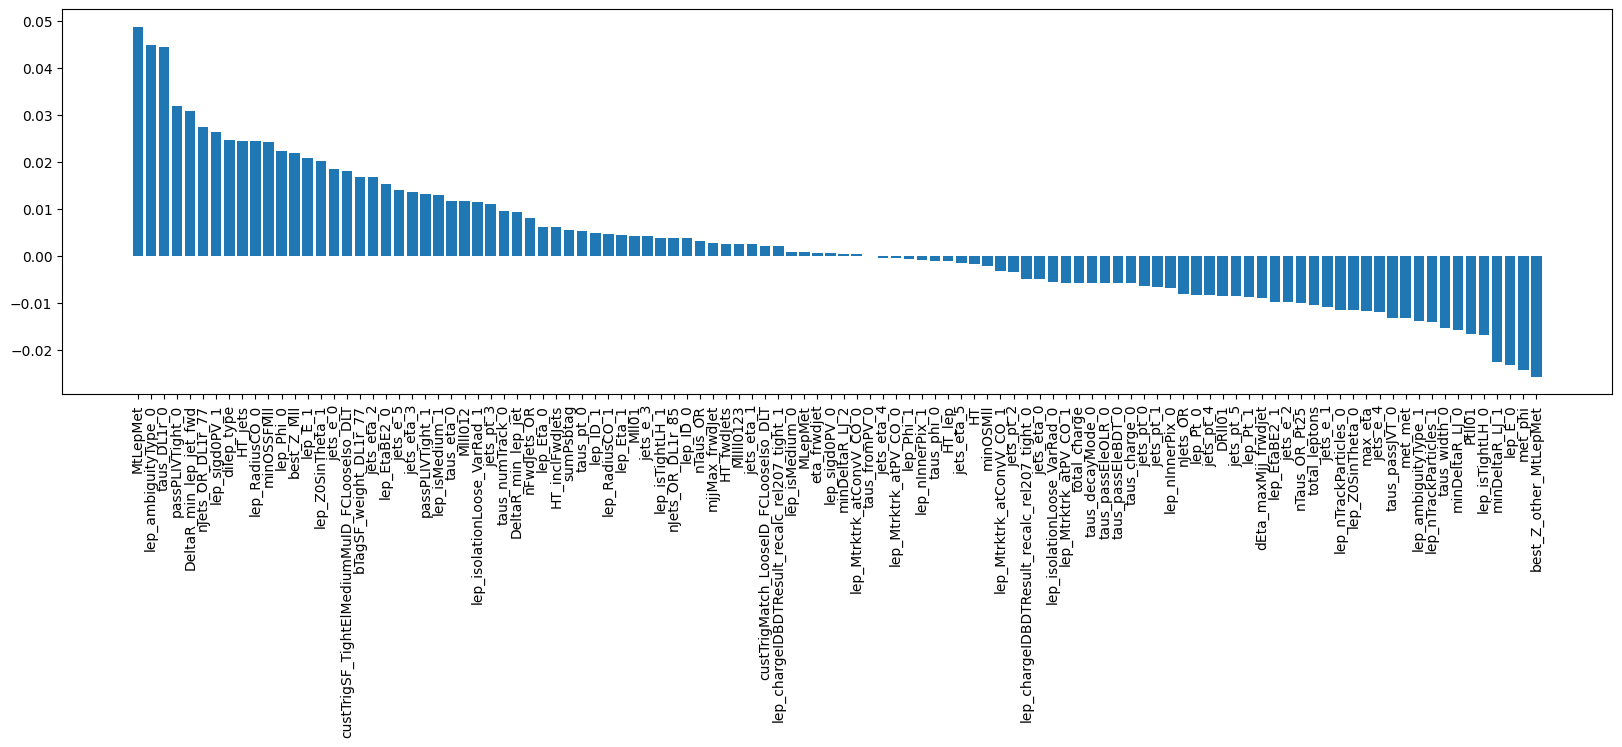

In [8]:
import matplotlib.pyplot as plt
from src.evaluation import feature_importance

plt.rcParams.update({'font.size': 10})

torch.manual_seed(0)

ig = feature_importance(model, val, val.y_names.index("ttH"), val.x_names, device=device, num_examples=10, plot="horizontal")

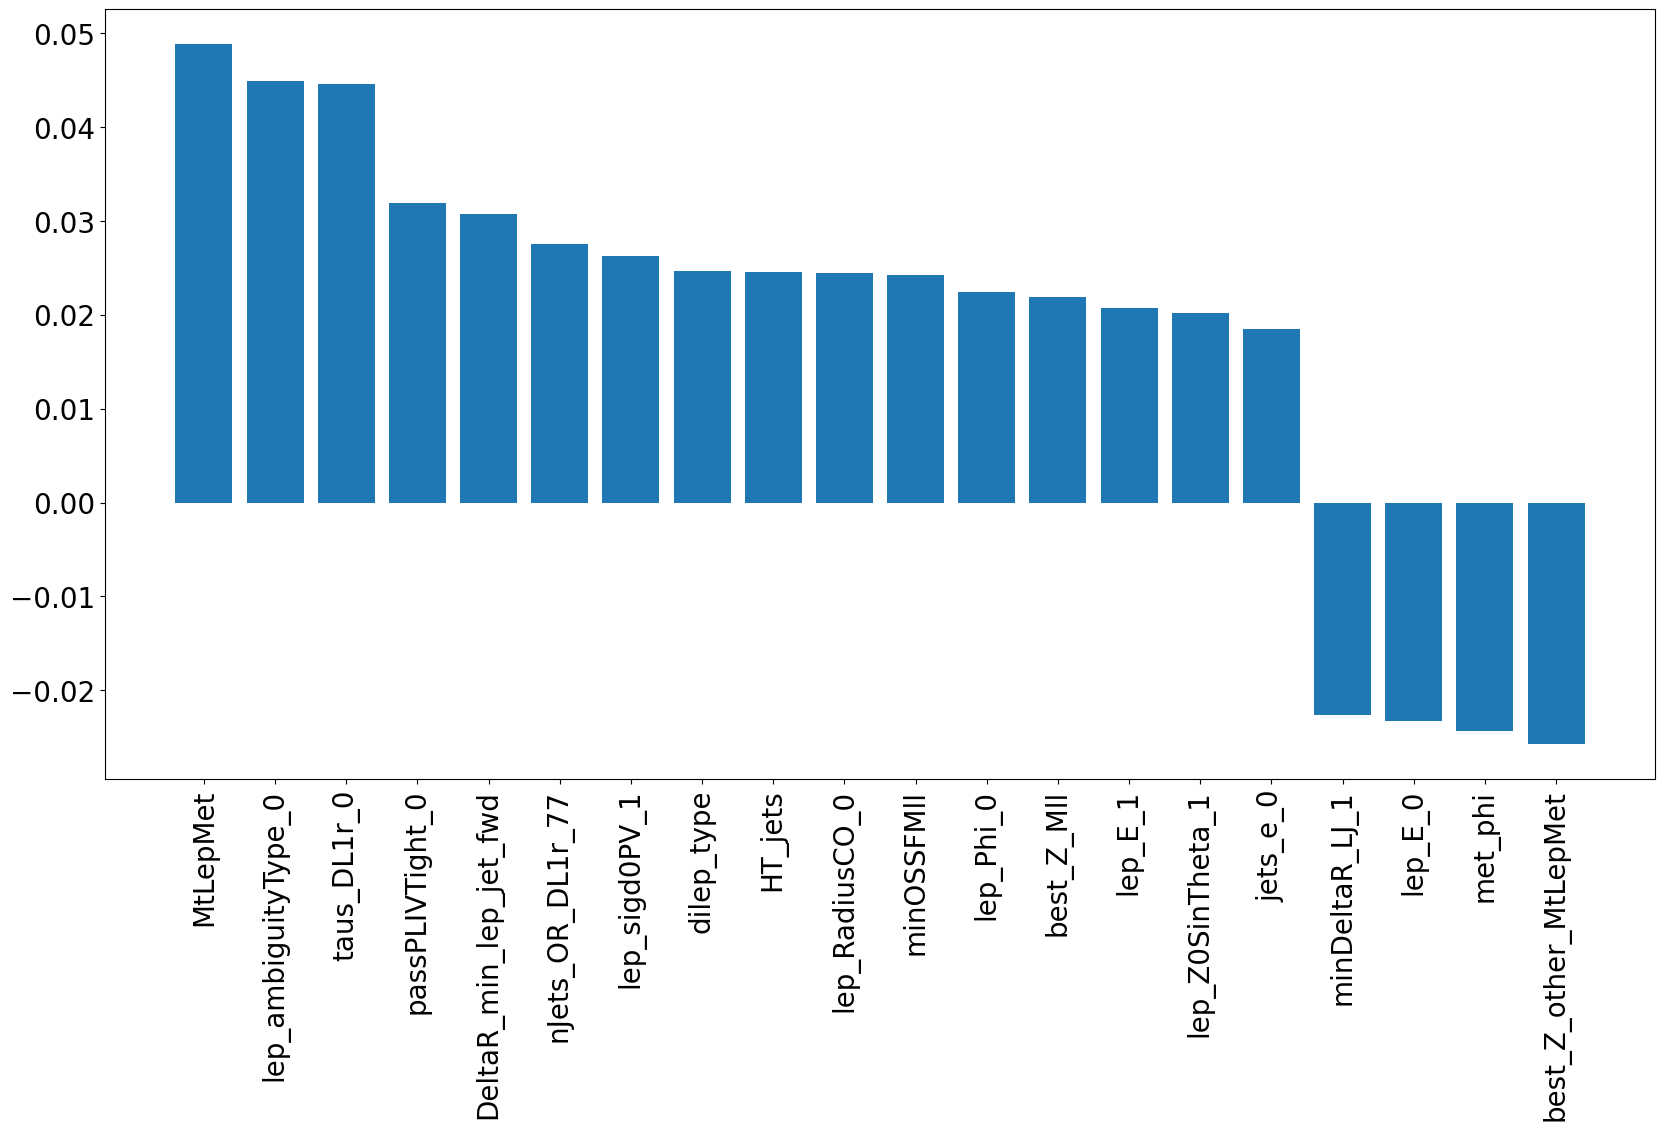

In [12]:
plt.rcParams.update({'font.size': 20})

n_features = 20
# Now we can plot the integrated gradients
# For now let's drop the object feature (our simple model doesn't use it anyway)
plt.figure(figsize=(20, 10))
ig_sorted, indices = torch.sort(ig.abs(), descending=False)
ig_sorted = ig[indices][-n_features:] # Use this if you also want to see positive/negative
indices = indices[-n_features:]

# Now also sort in ascending order
ig_sorted, ii = torch.sort(ig_sorted, descending=True)
indices = indices[ii]

# ig_sorted = ig_sorted[-n_features:]
plt.bar(torch.arange(len(ig_sorted)), ig_sorted.cpu())
plt.xticks(torch.arange(len(ig_sorted)), [val.x_names[i] for i in indices], rotation=90);

# Save probs to the root files

In [4]:
import os

# Get probs on the validation set
with torch.no_grad():
    probs_val = torch.cat([model(batch.to(device)) for batch in val.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1)
    probs_all = torch.cat([model(batch.to(device)) for batch in data_cut.batches(batch_size=batch_size, shuffle=False)]).softmax(dim=1)

In [11]:
import uproot

dirname = "output/nn_output"
if not os.path.exists(dirname):
    os.makedirs(dirname)

# For each class, create a ROOT file with a single histogram
for y_true, class_name in enumerate(val.y_names):
    file_name = f"{dirname}/{class_name}.root"
    selected_events = val.y == y_true

    p_signal = probs_val[selected_events, signal_idx]
    p_true = probs_val[selected_events, y_true]

    selected_weights = val.w.to(device)[selected_events]

    # We need to select the events where the selected class matches the label

    # This histogram will contain the probability of event being of class `label`
    # This will be a simple list of size `num_samples`
    with uproot.recreate(file_name) as root_file:
        root_file["nominal"] = { 
            f"p_{val.y_names[signal_idx]}": p_signal.cpu().numpy(),
            "p_true": p_true.cpu().numpy(),
            "weight": selected_weights.cpu().numpy()
        }

    with uproot.open(file_name) as root_file:
        print(class_name, root_file["nominal"][f"p_{val.y_names[signal_idx]}"].array())
        print(class_name, root_file["nominal"][f"p_true"].array())


ttH [0.366, 0.988, 0.585, 0.409, 0.202, ..., 0.805, 0.94, 0.411, 0.991, 0.679]
ttH [0.366, 0.988, 0.585, 0.409, 0.202, ..., 0.805, 0.94, 0.411, 0.991, 0.679]
ttW [0.241, 0.118, 0.0004, 0.00957, 0.0845, ..., 0.0184, 0.00453, 0.000684, 0.00213]
ttW [0.203, 0.552, 0.747, 0.105, 0.545, ..., 0.222, 0.27, 0.451, 0.659, 0.421]
ttW_EW [0.00894, 0.00162, 0.0926, 0.0444, 0.00694, ..., 0.48, 0.137, 0.161, 0.0481]
ttW_EW [0.0236, 0.0039, 0.0183, 0.00292, 0.0146, ..., 0.0011, 0.00512, 0.00467, 0.101]
ttZ [0.354, 0.0228, 0.0321, 0.000753, 0.893, ..., 0.00311, 0.945, 0.513, 0.208]
ttZ [0.228, 0.507, 0.918, 0.922, 0.0906, ..., 0.81, 0.344, 0.0138, 0.443, 0.623]
tt [0.605, 0.959, 0.63, 0.729, 0.928, 0.475, 0.705, 0.384]
tt [0.00942, 0.000831, 0.00866, 0.0283, 0.00731, 0.0104, 0.00496, 0.0261]
VV [0.00168, 0.0184, 0.000346, 0.811, ..., 0.0335, 0.000109, 0.0472, 2.94e-05]
VV [0.916, 0.000622, 0.95, 0.0177, 0.575, ..., 0.965, 0.735, 0.441, 0.563, 0.927]
tZ [0.378, 0.357, 0.99, 0.176, 0.287, 0.131, 0.623, 

In [12]:
import numpy as np


total = 0
total_w = 0
for y_true, class_name in enumerate(val.y_names):
    file_name = f"{dirname}/{class_name}.root"
    with uproot.open(file_name) as root_file:
        w = root_file["nominal"]["weight"].array().to_numpy().sum()
        print(f"{class_name} {w:.2f}")
        total += w
        total_w += val.w[val.y == y_true].sum().item()


print(f"Total weight: {total:.2f}, should be {total_w:.2f}")

ttH 2.51
ttW 2.12
ttW_EW 0.19
ttZ 2.62
tt 0.91
VV 0.92
tZ 0.08
WtZ 0.25
tW 0.00
threeTop 0.05
fourTop 0.26
ggVV 0.00
VVV 0.04
VH 0.00
ttWW 0.22
tHjb 0.03
tWH 0.02
Total weight: 10.21, should be 10.21


In [14]:
# We need to create a file preds.csv with the following columns:
# - eventNumber
# - ttH probability

event_numbers = np.array(data.metadata["event_numbers"])

event_numbers = event_numbers[selected]
probs_signal = probs_all[:, signal_idx]

# print(probs_signal.shape)
# print(event_numbers.shape)
# print(data_cut.n_samples)

# with open(f"{dirname}/preds.csv", "w") as f:
#     for event_number, prob in zip(event_numbers, probs_signal):
#         f.write(f"{event_number},{prob:.8f}\n")

# Save numpy arrays
np.save(f"{dirname}/event_numbers.npy", event_numbers)
np.save(f"{dirname}/probs_ttH.npy", probs_signal.cpu())
np.save(f"{dirname}/probs.npy", probs_all.cpu())

![probs](images/SR_probs.png)

# ONNX export

In [15]:
import torch

dummy_input = val[:1].to(device)
dummy_input = (dummy_input.x_continuous, dummy_input.x_categorical)

torch.onnx.export(
    model,
    dummy_input,
    "ft-transformer.onnx",
    verbose=True
)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 1 ERROR ========================
ERROR: missing-standard-symbolic-function
Exporting the operator 'aten::scaled_dot_product_attention' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.
None
<Set verbose=True to see more details>


Torch IR graph at exception: graph(%0 : Float(1, 108, strides=[108, 1], requires_grad=0, device=cuda:0),
      %1 : Long(1, 6, strides=[6, 1], requires_grad=0, device=cuda:0),
      %embed.w_nan : Float(108, strides=[1], requires_grad=1, device=cuda:0),
      %embed.w_categorical : Float(30, 256, strides=[256, 1], requires_grad=1, device=cuda:0),
      %embed.b_categorical : Float(6, 256, strides=[256, 1], requires_grad=1, device=cuda:0),
      %embed.w_continuous : Float(108, 256

UnsupportedOperatorError: Exporting the operator 'aten::scaled_dot_product_attention' to ONNX opset version 14 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

c.nn.transformer.MyEmbed::embed # /mnt/home.stud/yazykvla/tth/src/nn/transformer.py:238:0
  %2078 : Tensor?[] = prim::ListConstruct(%2077), scope: src.nn.transformer.TransformerNN::/src.nn.transformer.MyEmbed::embed
  %2079 : Float(1, 6, 256, strides=[1536, 256, 1], requires_grad=1, device=cuda:0) = aten::index(%embed.w_categorical, %2078), scope: src.nn.transformer.TransformerNN::/src.nn.transformer.MyEmbed::embed # /mnt/home.stud/yazykvla/tth/src/nn/transformer.py:238:0
  %2081 : Float(1, 6, 256, strides=[1536, 256, 1], requires_grad=1, device=cuda:0) = aten::add(%2079, %embed.b_categorical, %2541), scope: src.nn.transformer.TransformerNN::/src.nn.transformer.MyEmbed::embed # /mnt/home.stud/yazykvla/tth/src/nn/transformer.py:238:0
  %2082 : Tensor[] = prim::ListConstruct(%2075, %2081), scope: src.nn.transformer.TransformerNN::/src.nn.transformer.MyEmbed::embed
  %input.1 : Float(1, 114, 256, strides=[29184, 256, 1], requires_grad=1, device=cuda:0) = aten::cat(%2082, %2541), scope: sr